## Figure 4: Feature importance

This notebook reproduces Figure 4. It also includes boxplots showing the distributions of the most importance features.

In [1]:
use_extracted_data = True

In [2]:
import os
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load

from lib.check_files import (
    check_prepared_data,
)
from lib.feature_importance import (
    calculate_importances,
    get_ranks,
    plot_correlations,
    plot_importances,
)
from lib.misc import format_feature_name
from lib.pu import (
    COLUMNS_TO_DROP,
    CORRELATED_COLUMNS,
    PRESERVATION_COLUMNS,
)

In [3]:
colour = True

colours = {
    "All": "green",
    "NA": "red",
    "SA": "blue",
}
boxprops = {
    "All": {"hatch": "x"},
    "NA": {"hatch": "\\"},
    "SA": {"hatch": "/"},
}
for key, value in boxprops.items():
    if colour:
        col = colours[key]
    else:
        col = "none"
    value["facecolor"] = col

### Load PU classifiers and training data

In [21]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
training_filename = os.path.join(data_dir, "training_data.csv")
outputs_dir = "outputs"

figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)
supplement_dir = "supplementary_figures"
os.makedirs(supplement_dir, exist_ok=True)

regions = ("All", "NA", "SA")
regions = ("All", "north_america", "south_america")
models = {}
for region in regions:
    if region == "All":
        classifier_filename = "Americas/PU/classifier.joblib"
    else:
        classifier_filename = f"pu_classifier_{region}.joblib"
        classifier_filename = f"Americas/PU/classifier_{region}.joblib"
    classifier_filename = os.path.join(
        outputs_dir,
        classifier_filename,
    )
    models[region] = load(classifier_filename)
    models[region] = models[region].named_steps[list(models[region].named_steps.keys())[-1]]

df_training = pd.read_csv(training_filename)
importances_basename = os.path.join(figures_dir, "Fig-03-feature_importances")
boxplots_filename = os.path.join(figures_dir, "Fig-04-feature_boxplots")
correlation_filename = os.path.join(supplement_dir, "feature_importance_correlation")

to_drop = COLUMNS_TO_DROP | CORRELATED_COLUMNS | PRESERVATION_COLUMNS
to_drop.add("label")
feature_names = sorted(set(df_training.columns).difference(to_drop))
feature_names = np.array(feature_names, dtype="object")

In [16]:
models['All'].named_steps
models['All']

Pipeline(steps=[('iterativeimputer', IterativeImputer(random_state=1234)),
                ('robustscaler', RobustScaler()),
                ('baggingpuclassifier',
                 BaggingPuClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                                      n_jobs=1,
                                                                      random_state=1234),
                                     n_estimators=100, n_jobs=8,
                                     random_state=1234))])

### Calculate feature importances

In [22]:
importances = {
    region: calculate_importances(model, feature_names)
    for region, model in models.items()
}

pd.concat(
    [
        pd.DataFrame(
            {
                f"{region}: importance (relative)": values / values.max(),
                f"{region}: importance (absolute)": values,
            }
        )
        for region, values in importances.items()
    ],
    axis="columns",
).sort_values(by="All: importance (relative)", ascending=False)

,All: importance (relative),All: importance (absolute),north_america: importance (relative),north_america: importance (absolute),south_america: importance (relative),south_america: importance (absolute)
trench_velocity_orthogonal (cm/yr),1.000000,0.119813,1.000000,0.119813,1.000000,0.119813
trench_velocity_parallel (cm/yr),0.886560,0.106222,0.886560,0.106222,0.886560,0.106222
trench_velocity_obliquity (degrees),0.600344,0.071929,0.600344,0.071929,0.600344,0.071929
distance_to_trench_edge (degrees),0.541250,0.064849,0.541250,0.064849,0.541250,0.064849
crustal_thickness_mean (m),0.426110,0.051054,0.426110,0.051054,0.426110,0.051054
seafloor_spreading_rate (km/Myr),0.389116,0.046621,0.389116,0.046621,0.389116,0.046621
convergence_rate_parallel (cm/yr),0.384432,0.046060,0.384432,0.046060,0.384432,0.046060
subducted_sediment_volume (m),0.365011,0.043733,0.365011,0.043733,0.365011,0.043733
subducting_plate_absolute_velocity_orthogonal (cm/yr),0.342740,0.041065,0.342740,0.041065,0.342740,0.041065
subducted_carbonates_volume (m),0.321831,0.038560,0.321831,0.038560,0.321831,0.038560


### Plot feature importances (bar chart)

In [23]:
normalise = True  # show relative importance values
num_to_keep = 6  # show 6 most important features

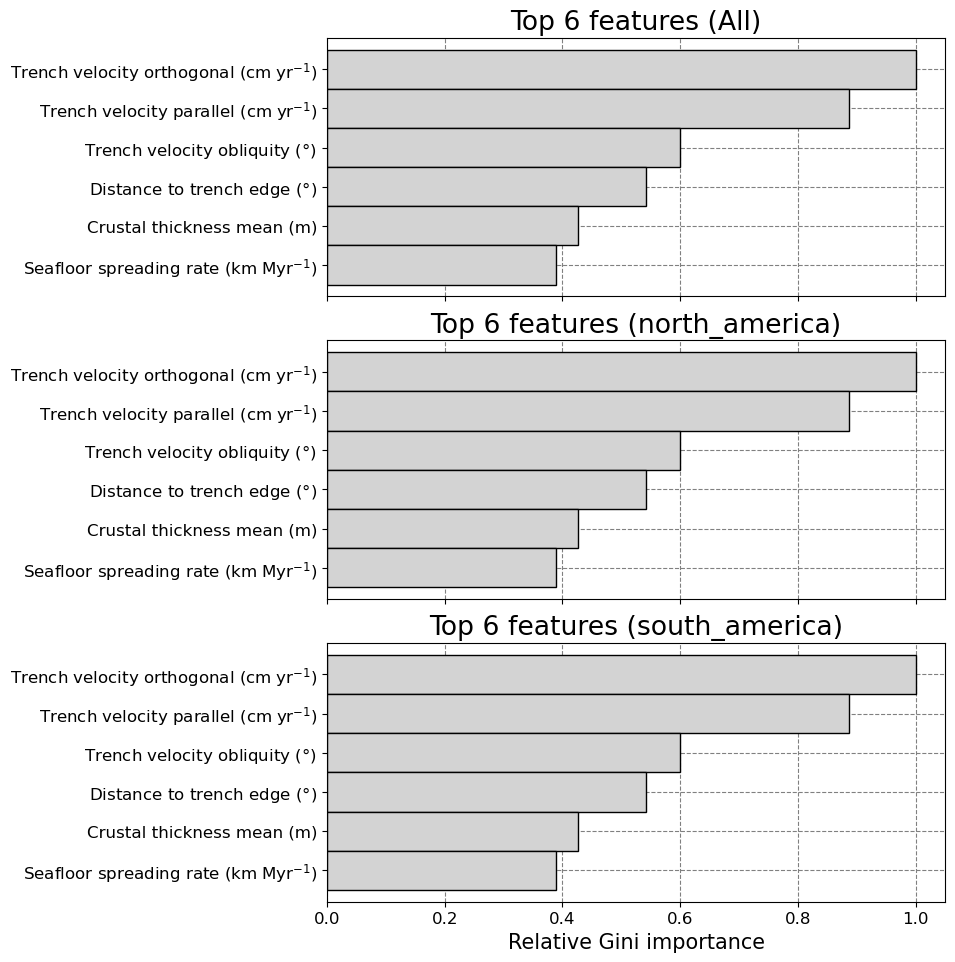

In [24]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(num_to_keep * 1.33, num_to_keep * 1.87),
    gridspec_kw={"hspace": 0.17},
)
for ax, region in zip(axs, regions):
    title = f"Top {num_to_keep} features ({region})"
    plot_importances(
        models[region],
        names=feature_names,
        normalise=normalise,
        num_to_keep=num_to_keep,
        ax=ax,
        title=title,
        fontsize=12,
        titlesize=19.2,
    )
    if ax is not axs[-1]:
        ax.set_xlabel(None)
        ax.tick_params(labelbottom=False)

for extension in (".png", ".pdf"):
    output_filename = importances_basename + extension
    fig.savefig(
        output_filename,
        dpi=350,
        bbox_inches="tight",
    )

### Compare feature importance rankings

In [25]:
importances = {
    region: calculate_importances(model, feature_names)
    for region, model in models.items()
}
ranks = {
    region: get_ranks(values) for region, values in importances.items()
}
ranks = pd.concat(
    [
        pd.DataFrame(rank_values, columns=[f"Rank ({region})"])
        for region, rank_values in ranks.items()
    ],
    axis="columns",
)

In [26]:
sort_by = "All"

ranks.sort_values(f"Rank ({sort_by})")

,Rank (All),Rank (north_america),Rank (south_america)
trench_velocity_orthogonal (cm/yr),1,1,1
trench_velocity_parallel (cm/yr),2,2,2
trench_velocity_obliquity (degrees),3,3,3
distance_to_trench_edge (degrees),4,4,4
crustal_thickness_mean (m),5,5,5
seafloor_spreading_rate (km/Myr),6,6,6
convergence_rate_parallel (cm/yr),7,7,7
subducted_sediment_volume (m),8,8,8
subducting_plate_absolute_velocity_orthogonal (cm/yr),9,9,9
subducted_carbonates_volume (m),10,10,10


All/north_america: tau = 1.00, p = 0.00
All/south_america: tau = 1.00, p = 0.00
north_america/south_america: tau = 1.00, p = 0.00


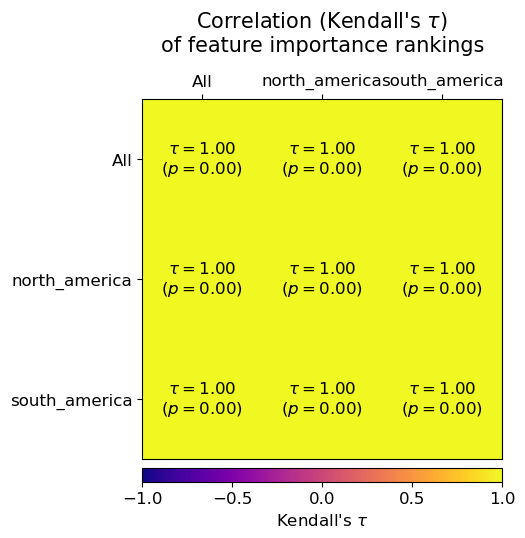

In [27]:
fig = plot_correlations(
    models,
    names=feature_names,
    verbose=True,
    cmap="plasma" if colour else "Greys",
    text_kw={"color": "black" if colour else "white"}
)
for ext in (".pdf", ".png"):
    output_filename = correlation_filename + ext
    fig.savefig(output_filename, dpi=350, bbox_inches="tight")

### Plot important feature distributions (box plots)

In [36]:
importances_sorted = importances["All"].sort_values(ascending=False)
columns = importances_sorted.iloc[:num_to_keep].index

df_boxplots = df_training.copy()
#print(df_boxplots)
#df_boxplots = df_boxplots[df_boxplots["region"].isin({"NAm", "SAm"})]
df_boxplots = df_boxplots[df_boxplots["region"].isin({"North America", "South America"})]

mean_values = pd.concat(
    [
        df_boxplots,
        df_boxplots.assign(region="All"),
    ]
).groupby(["region", "label"])[columns].mean()
print("Mean values:")
mean_values.T

Mean values:


region                                        All                              \
label                                    negative      positive    unlabelled   
trench_velocity_orthogonal (cm/yr)      -0.601528     -2.049202     -0.908272   
trench_velocity_parallel (cm/yr)        -1.119320     -1.307848     -0.450902   
trench_velocity_obliquity (degrees)   -118.070781    -97.177488    -42.144415   
distance_to_trench_edge (degrees)        6.074141      7.604209      6.856568   
crustal_thickness_mean (m)           35734.750701  36604.574839  33722.840334   
seafloor_spreading_rate (km/Myr)       106.663556    117.725246     93.434735   

region                              North America                              \
label                                    negative      positive    unlabelled   
trench_velocity_orthogonal (cm/yr)      -1.108740     -2.596788     -1.104514   
trench_velocity_parallel (cm/yr)        -1.317042     -1.292518     -0.306007   
trench_velocity_obliquity (degrees)   -114.884550    -73.636558    -18.983638   
distance_to_trench_edge (degrees)        8.639960      4.666881      5.331825   
crustal_thickness_mean (m)           32793.937226  37257.151149  34121.096454   
seafloor_spreading_rate (km/Myr)       116.742181    105.724585     83.174118   

region                              South America                              
label                                    negative      positive    unlabelled  
trench_velocity_orthogonal (cm/yr)      -0.571996     -1.310396     -0.676615  
trench_velocity_parallel (cm/yr)        -1.107808     -1.328531     -0.621945  
trench_velocity_obliquity (degrees)   -118.256292   -128.939060    -69.484833  
distance_to_trench_edge (degrees)        5.924752     11.567270      8.656469  
crustal_thickness_mean (m)           35905.972732  35724.114738  33296.861679  
seafloor_spreading_rate (km/Myr)       106.076751    133.916616    105.547004

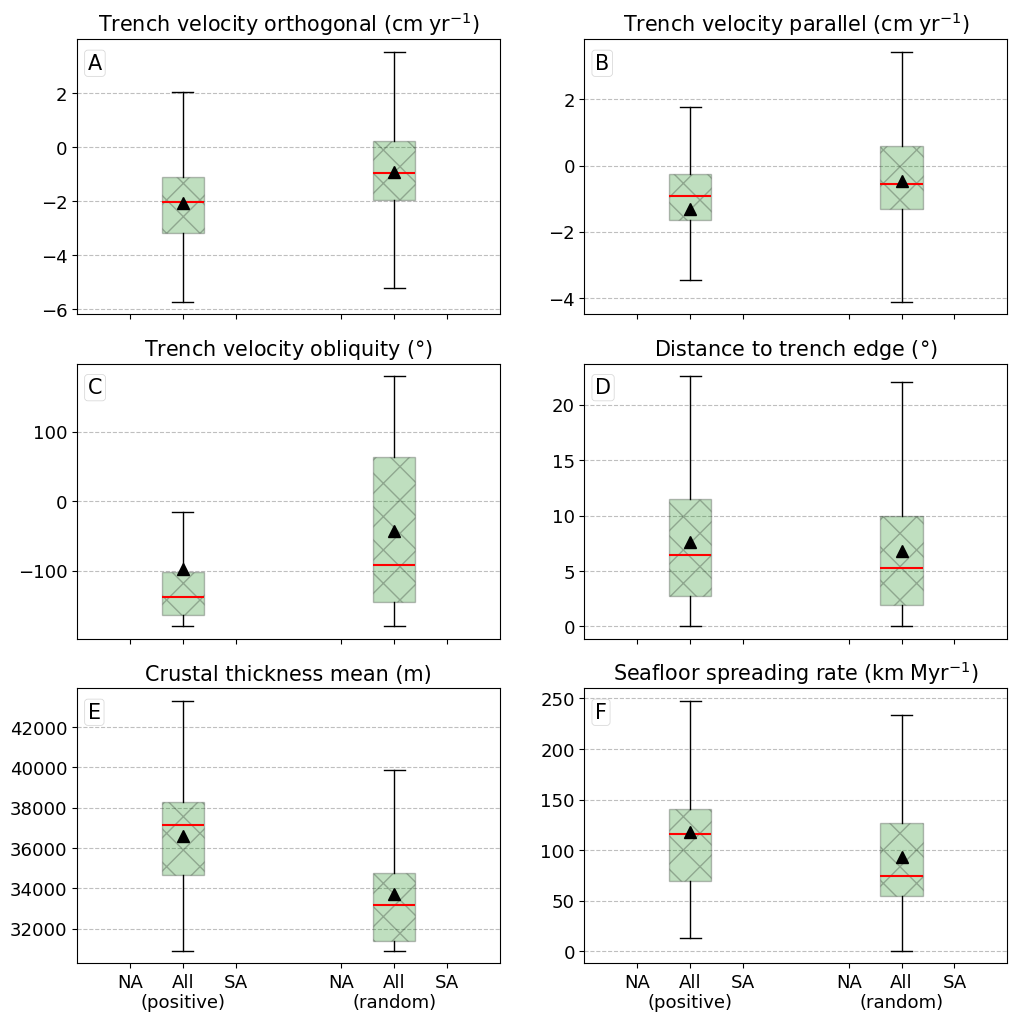

In [37]:
label_filters = {
    i: df_boxplots["label"] == i
    for i in ("positive", "unlabelled")
}
region_filters = {
    "All": np.full(df_boxplots.shape[0], True),
    **{i: df_boxplots["region"] == i + "m" for i in ("NA", "SA")}
}

disp = 0.25
fontsize = 13
titlesize = fontsize * 1.15

data = []
keys = []
positions = []
for i, label in enumerate(label_filters.keys()):
    for j, region in enumerate(("NA", "All", "SA")):
        filt = (label_filters[label]) & (region_filters[region])
        keys.append((label, region))
        data.append(df_boxplots[filt])
        positions.append(i + (j - 1) * disp)
positions = np.array(positions)
xlims = (positions.min() - disp, positions.max() + disp)

fig, axs = plt.subplots(
    3, 2,
    figsize=(12, 12),
    gridspec_kw={"hspace": 0.18},
)

for i, (column, ax) in enumerate(
    zip(
        columns,
        np.ravel(axs),
    )
):
    panel_label = ascii_uppercase[i]
    for d, key, position in zip(data, keys, positions):
        label, region = key
        ticklabel = region
        if i >= num_to_keep - 2:
            if region == "All":
                if label == "positive":
                    ticklabel += "\n(positive)"
                else:
                    ticklabel += "\n(random)"
        else:
            ticklabel = ""

        ax.boxplot(
            d[column].dropna(),
            positions=[position],
            patch_artist=True,
            boxprops={**(boxprops[region]), "alpha": 0.25},
            showfliers=False,
            showmeans=True,
            meanprops=dict(
                marker="^",
                markerfacecolor="black",
                markeredgecolor="black",
                markersize=8,
            ),
            medianprops=dict(
                color="red",
                linewidth=1.5,
            ),
            labels=[ticklabel],
            widths=[disp * 0.8],
        )

    ax.text(
        0.025, 0.95,
        panel_label,
        ha="left",
        va="top",
        fontsize=titlesize,
        transform=ax.transAxes,
        bbox=dict(
            facecolor="white",
            edgecolor="lightgrey",
            linewidth=0.5,
            boxstyle="Round, pad=0.15, rounding_size=0.15",
        )
    )
    ax.set_title(format_feature_name(column), fontsize=titlesize)
    ax.set_xlim(*xlims)
    ax.grid(linestyle="dashed", color="grey", alpha=0.5, axis="y")
    ax.tick_params(labelsize=fontsize)

for ext in (".png", ".pdf"):
    output_filename = boxplots_filename + ext
    fig.savefig(
        output_filename,
        dpi=350,
        bbox_inches="tight",
    )